In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

# Verified Neural System Identification and Control

This notebook contains some exploratory code, directed towards the problem of 

1. learning the dynamics of a discrete-time dynamical system,
2. learning (simultaneously) a stabilizing controller for the system and a Lyapunov stability certificate, and
3. verifying that the Lyapunov property holds despite some bounded error in system identification

## Theory

Consider a discrete-time dynamical system $x_{t+1} = f(x_t, u_t)$, where $x \in \mathcal{X} \subset \mathbb{R}^n$ and $u \in \mathcal{U} \subset \mathbb{R}^m$, equipped with a feedback controller $u = \pi(x)$. This gives us the closed-loop dynamics $$x_{t+1} = f(x_t, \pi(x_t)) = f_\pi(x_t)$$

Assume the closed-loop system has a fixed point $x^*$ such that $f_\pi(x^*) = x^*$. Let $V(x): \mathbb{R}^n \to \mathbb{R}$. Then the closed loop system will be asymptotically stable at $x^*$ if the following hold:

1. $V(x^*) = 0$
2. $V(x) > 0;\quad \forall x \in (\mathcal{X} - x^*)$
3. $V(x_{t+1}) - V(x_t) < 0;\quad \forall x \in (\mathcal{X} - x^*)$

We can also express (3) in terms of the closed-loop dynamics: $V\circ f_\pi(x_t) - V(x_t) < 0$.

## Approach

We will approach this problem in three steps.

1. First, we will learn the open-loop system dynamics $f(x, u)$ from trajectories, using a neural network with ReLU activations.
2. Next, we will fix the learned dynamics and simultaneously learn a controller $\pi(x)$ and Lyapunov function $V(x)$, using a loss that guides us towards satisfying conditions (1)-(3) above.
3. Finally, we will verify that conditions (2) and (3) hold throughout the domain.

## Step 1: Learn dynamics from data

We'll use a simple nonlinear pendulum model here and try to learn the dynamics

In [2]:
# Start by building an oracle for the system dynamics. This will be used to generate training trajectories
def f_true(x, u):
    """damped pendulum discrete-time dynamics, with theta=0 pointing straight upwards
    """
    # Define parameters
    dt = 0.01  # timestep
    l = 1
    m = 1
    g = 9.8
    b = 0.1
    
    # Construct the derivatives. The state is [theta, theta_dot], so derivatives are [theta_dot, u-mgl*sin(theta) - b*theta_dot]
    xdot = torch.zeros(x.shape)
    xdot[:, 0] = x[:, 1]
    xdot[:, 1] = u.squeeze() / (m*l**2) - g/l*torch.sin(np.pi + x[:, 0]) - b/(m*l**2) * x[:, 1]
    
    return x + dt * xdot


In [3]:
# Gather training and test data by sampling directly from the joint state/action space
# We'll use the test data to characterize the error in the learned dynamics.
N_train = 1000000
N_test = 200000

x_min = torch.zeros((2,))
x_min[0] = -np.pi
x_min[1] = -3*np.pi
x_max = -1 * x_min
u_max = torch.tensor([20])
u_min = -u_max

x_train = torch.rand((N_train, 2))
x_train[:, 0] = x_train[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
x_train[:, 1] = x_train[:, 1] * (x_max[1] - x_min[1]) + x_min[1]
u_train = torch.rand((N_train, 1)) * (u_max[0] - u_min[0]) + u_min[0]

x_test = torch.rand((N_test, 2))
x_test[:, 0] = x_test[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
x_test[:, 1] = x_test[:, 1] * (x_max[1] - x_min[1]) + x_min[1]
u_test = torch.rand((N_test, 1)) * (u_max[0] - u_min[0]) + u_min[0]

f_train = f_true(x_train, u_train)
f_test = f_true(x_test, u_test)

In [4]:
# Define hyperparameters for the learning process
learning_rate = 1e-3
batch_size = 1024
max_epochs = 300

n_dims = 2
n_controls = 1

# Optionally load a model instead of training a new one
use_saved_model = True
if use_saved_model:
    filename = 'logs/pendulum_model_best.pth.tar'
    loaded_data = torch.load(filename)

# Define the network for learning the dynamics
if use_saved_model:
    n_hidden_layers = loaded_data['n_hidden_layers']
    hidden_layer_size = loaded_data['neurons_per_layer']
else:
    n_hidden_layers = 2
    hidden_layer_size = 32

layers = []
# Input layer: inputs are states and controls, outputs are hidden layer activations
input_layer = [nn.Linear(n_dims + n_controls, hidden_layer_size), nn.ReLU()]
layers = layers + input_layer
# Hidden layers: inputs and outputs are the same size
for i in range(n_hidden_layers - 1):
    hidden_layer = [nn.Linear(hidden_layer_size, hidden_layer_size), nn.ReLU()]
    layers = layers + hidden_layer
# Output layer: outputs new states
layers = layers + [nn.Linear(hidden_layer_size, n_dims)]

# Build the network from these components
dynamics_model = nn.Sequential(*layers)
if use_saved_model:
    dynamics_model.load_state_dict(loaded_data['dynamics_model'])
    dynamics_model.eval()

# Train the dynamics model (if we haven't already loaded one)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.5 ** (epoch // 15))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Define the loss function
loss_fn = nn.L1Loss()

# Train the network
optimizer = optim.Adam(dynamics_model.parameters(), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

# Skip training if we've already loaded a model
if use_saved_model:
    max_epochs = 0
    epoch = 0

epochs = tqdm(range(max_epochs))
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get input/output pairs
        indices = permutation[i:i+batch_size]
        x = x_train[indices]
        u = u_train[indices]
        next_state = f_train[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_next_state = dynamics_model(torch.hstack((x, u)))

        # Compute loss and backpropagate
        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        loss_acumulated += loss.item()
        loss.backward()

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Get input/output pairs
        x = x_test
        u = u_test
        next_state = f_test

        predicted_next_state = dynamics_model(torch.hstack((x, u)))

        loss = loss_fn(predicted_next_state, next_state)
        loss += torch.max(torch.norm(predicted_next_state - next_state, dim=1))
        test_losses.append(loss)
        epochs.set_description(f"Test loss: {round(loss.item(), 6)}")

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/pendulum_model_best.pth.tar'
            torch.save({'n_hidden_layers':n_hidden_layers,
                        'neurons_per_layer':hidden_layer_size,
                        'dynamics_model': dynamics_model.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

/home/cbd/anaconda3/envs/neural_control/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


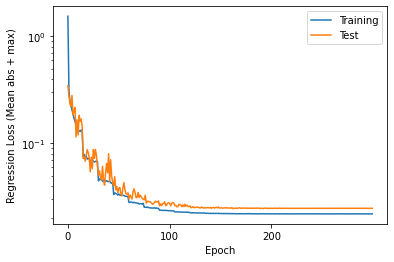

In [5]:
# Plot the loss curves
plt.figure()
plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(len(test_losses)), test_losses)
plt.gca().set_xticks(np.arange(0, epoch+1, 100))
plt.xlabel("Epoch")
plt.ylabel("Regression Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

In [6]:
loss_acumulated = 0.0
with torch.no_grad():
    next_state = f_test

    predicted_next_state = dynamics_model(torch.hstack((x_test, u_test)))

    loss = loss_fn(predicted_next_state, next_state)
    print(f"Test loss (mean L1): {round(loss.item(), 4)}")
    loss = torch.mean(torch.norm(predicted_next_state - next_state, dim=1))
    print(f"Test loss (mean L2): {round(loss.item(), 4)}")
    loss = torch.max(torch.norm(predicted_next_state - next_state, p=1, dim=1))
    print(f"Test loss (max L1): {round(loss.item(), 4)}")
    loss = torch.max(torch.norm(predicted_next_state - next_state, dim=1))
    print(f"Test loss (max L2): {round(loss.item(), 4)}")

Test loss (mean L1): 0.0042
Test loss (mean L2): 0.0073
Test loss (max L1): 0.0265
Test loss (max L2): 0.0205


## Step 2: Learn a controller to stabilize and provide forward set invariance

Now that we've learned the dynamics, we can design a controller using those dynamics. Our goals for this controller are to:

1. Stabilize to the upright position (theta = theta_dot = 0)

In [111]:
x_goal = torch.tensor([[0.0, 0.0]])
# Now we can gather training and test points
# (basically samples from the state space, segmented into safe an unsafe regions)
N_train = 100000
N_test = 50000

x_min = torch.zeros((2,))
x_min[0] = -np.pi
x_min[1] = -3*np.pi
x_max = -1 * x_min

# Sample training points
x_train = torch.rand((N_train, 2))
x_train[:, 0] = x_train[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
x_train[:, 1] = x_train[:, 1] * (x_max[1] - x_min[1]) + x_min[1]

# And some test points
x_test = torch.rand((N_test, 2))
x_test[:, 0] = x_test[:, 0] * (x_max[0] - x_min[0]) + x_min[0]
x_test[:, 1] = x_test[:, 1] * (x_max[1] - x_min[1]) + x_min[1]
x_safe_test = x_test  # no unsafe region in this case
dist_to_goal_safe_test = torch.linalg.norm(x_safe_test - x_goal, dim=-1)

<IPython.core.display.Javascript object>


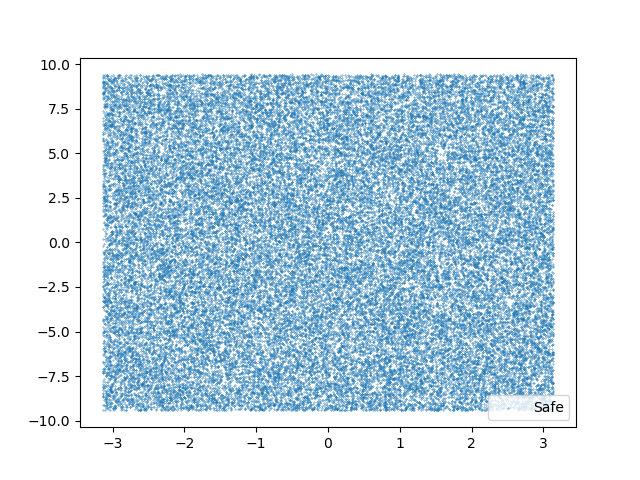

In [112]:
plt.figure()
plt.scatter(x_test[:, 0], x_test[:, 1], 0.1)
plt.legend(["Safe", "Unsafe"], loc='lower right')

In [113]:
# Now we have to define the controller and Lyapunov networks. For ease of composition later on,
# we'll define these as two different classes of network

class ControllerReLUNet(nn.Module):
    """A class to represent a controller for a dynamical system, using ReLU activations"""

    def __init__(self, n_dims, n_controls):
        super(ControllerReLUNet, self).__init__()

        self.feedback_layer = nn.Linear(n_dims, 1, bias=False)

        # Initialize the controller to be negative feedback.
        self.feedback_layer.weight = torch.nn.Parameter(torch.tensor([[-10.0, 0.0]]))
        
    def forward(self, x):
        """Compute the control input for state x"""
        return self.feedback_layer(x)


class LyapunovNet(nn.Module):
    """A class to represent a lyapunov function for a dynamical system, using a max of affine functions"""

    def __init__(self, n_dims):
        super(LyapunovNet, self).__init__()
        
        # This is kind of a peculiar network structure. We want the Lyapunov function to be convex,
        # so we construct it as a max of a bunch of affine functions
        self.num_affine_units = 32
        self.affine_layer = nn.Linear(n_dims, self.num_affine_units, bias=False)
        
    def forward(self, x):
        """Compute the Lyapunov function value for state x"""
        # Compute the value of each affine function (if x is bs x 3, then this should be bs x num_affine_units)
        affine_unit_values = self.affine_layer(x)
        
        # Take a leaky maximum of the affine functions
        # This should be bs x 1
        output, _ = torch.max(affine_unit_values, dim=-1)
        output += 0.1 * torch.mean(affine_unit_values, dim=-1)
        return output

In [146]:
def lyapunov_loss(x_goal, x_safe, u, dynamics_model, lyapunov_model, dist_to_goal):
    """Penalize any portion of the safe state space where the Lyapunov function does not satisfy
    the Lyapunov conditions.
    
    args:
        x_goal - N_goal x 3 tensor of points in the goal region
        x_safe - N_safe x 3 tensor of points in the safe region
        u - Nx1 tensor of control inputs for each point
        dynamics_model - a NN that takes [x, y, theta, u]_t and returns [x, y, theta]_{t+1}
        lyapunov_model - a NN that takes [x, y, theta] and returns V
        dist_to_goal - N_safe x 3 tensor of distance from x_safe to goal region
    """
    # There are three conditions on the Lyapunov function V(x).
    #   1.) V(x) = 0 in the goal region and >= 0 elsewhere
    #   2.) V(x) is convex
    #   3.) V(x_{t+1}) - V(x_t) < 0
    #
    # (2) is satisfied by construction, and we add a loss term for the other two

    loss = 0.0
    relu = nn.ReLU()
    
    # Add a term to encourage (1)
    loss += torch.mean(lyapunov_model(x_goal) ** 2)
    V_now = lyapunov_model(x_safe)
    eps = 0.001
    loss += relu(eps - V_now).mean()
    
    # Add a term to encourage (3)
    inputs = torch.hstack((x_safe, u))
    x_next = dynamics_model(inputs)
    V_next = lyapunov_model(x_next)
    lambda_lyap = 0.0
    loss += relu(eps + V_next - V_now + lambda_lyap * dist_to_goal).sum()

    
    return loss

Now that we've defined all the needed networks and loss functions, we can start training!

In [147]:
# Define hyperparameters for the learning process
learning_rate = 1e-3
batch_size = 1024
max_epochs = 500

# Optionally load a model instead of training a new one
use_saved_model = False
if use_saved_model:
    filename = 'logs/combined_pendulum_controller_lyap_dynamics.pth.tar'
    loaded_data = torch.load(filename)

# Define the network for learning the controller and certificates
controller = ControllerReLUNet(n_dims, n_controls)
lyap_function = LyapunovNet(n_dims)

if use_saved_model:
    controller.load_state_dict(loaded_data['controller'])
    controller.eval()
    lyap_function.load_state_dict(loaded_data['lyap_function'])
    lyap_function.eval()


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate * (0.8 ** (epoch // 30))
    lr = max(1e-6, lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the networks
optimizer = optim.Adam(list(controller.parameters())
                       + list(lyap_function.parameters()), lr=learning_rate)

# Also log histories of training and test loss
training_losses = []
test_losses = []
best_loss = np.inf

# Skip training if we've already loaded a model
if use_saved_model:
    max_epochs = 0
    epoch = 0

epochs = tqdm(range(max_epochs))
print("Starting training")
for epoch in epochs:
    # Set the adaptive learning rate
    adjust_learning_rate(optimizer, epoch)

    # Randomize the presentation order in each epoch
    permutation = torch.randperm(N_train)

    loss_acumulated = 0.0
    for i in range(0, N_train, batch_size):
        # Get samples from the state space
        indices = permutation[i:i+batch_size]
        x = x_train[indices]
        
        # all points are safe in this case
        x_safe = x
        
        # Get distance from each point to the goal
        dist_to_goal_safe = torch.linalg.norm(x_safe - x_goal, dim=-1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass to get the controller output (the forward pass for the lyapunov and barrier functions
        # happens inside the lyapunov loss function)
        u_safe = controller(x_safe)
        u_goal = controller(x_goal)

        # Compute loss and backpropagate
        loss = 0.0
        loss += lyapunov_loss(x_goal, x_safe, u_safe, dynamics_model, lyap_function, dist_to_goal_safe)
        loss.backward()
        
        loss_acumulated += loss

        # Update the parameters
        optimizer.step()

    # save progress
    training_losses.append(loss_acumulated.detach().item() / (N_train / batch_size))

    # Reset accumulated loss and get loss for the test set
    loss_acumulated = 0.0
    with torch.no_grad():
        # Use samples from the state space segmented as safe/unsafe/goal to compute test loss
        u_safe = controller(x_safe_test)
        u_goal = controller(x_goal)

        # Compute loss and backpropagate
        loss = 0.0
        lyap_loss = lyapunov_loss(x_goal, x_safe_test, u_safe, dynamics_model, lyap_function, dist_to_goal_safe_test)
        loss += lyap_loss

        epochs.set_description(f"Test loss: {round(loss.item(), 8)}")
        test_losses.append(loss.detach().item())

        if loss <= best_loss:
            best_loss = loss
            filename = 'logs/combined_pendulum_controller_lyap_dynamics.pth.tar'
            torch.save({'dynamics_model': dynamics_model.state_dict(),
                        'controller': controller.state_dict(),
                        'lyap_function': lyap_function.state_dict(),
                        'training_losses': training_losses,
                        'test_losses': test_losses}, filename)

Starting training



<IPython.core.display.Javascript object>


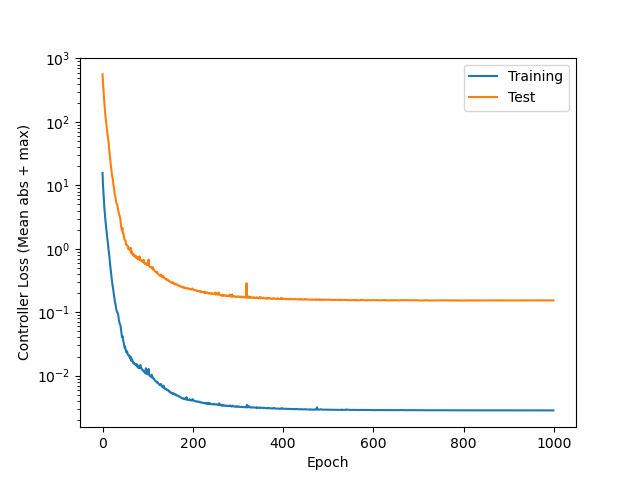

In [152]:
# Plot the total loss curves
plt.figure()
plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(len(test_losses)), test_losses)
# plt.gca().set_xticks(np.arange(0, epoch+1, 5))
plt.xlabel("Epoch")
plt.ylabel("Controller Loss (Mean abs + max)")
plt.legend(["Training", "Test"])
plt.yscale("log")

<IPython.core.display.Javascript object>


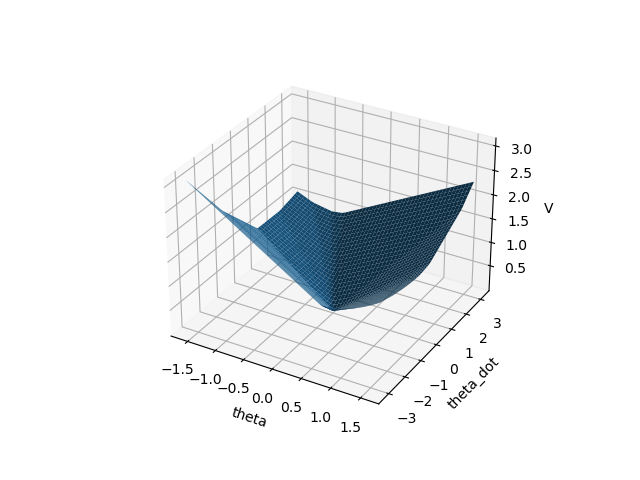

<IPython.core.display.Javascript object>


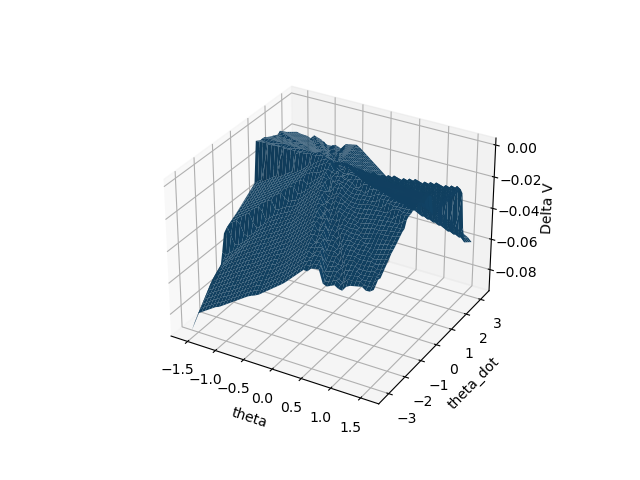

<IPython.core.display.Javascript object>


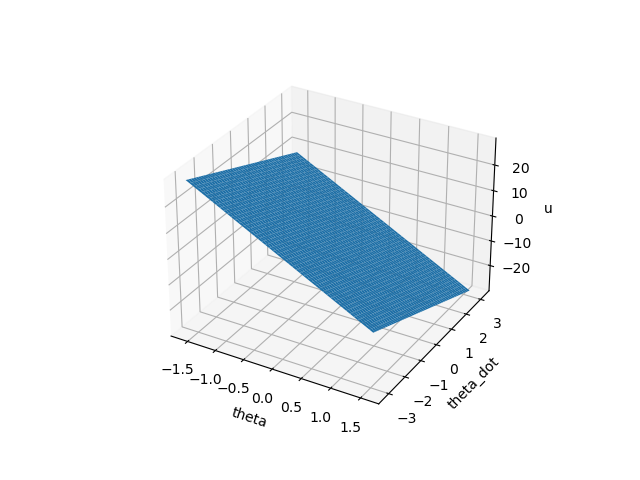

In [153]:
# Plot the Lyapunov function
with torch.no_grad():
    n_pts = 50
    theta = torch.linspace(-np.pi/2, np.pi/2, n_pts)
    theta_dot = torch.linspace(-np.pi, np.pi, n_pts)
    grid_theta, grid_theta_dot = torch.meshgrid(theta, theta_dot)
    us = torch.zeros(n_pts, n_pts)
    V_values = torch.zeros(n_pts, n_pts)
    V_delta_values = torch.zeros(n_pts, n_pts)
    for i in range(n_pts):
        for j in range(n_pts):
            state = torch.tensor([[theta[i], theta_dot[j]]])
            V_values[i, j] = lyap_function(state)
            u = controller(state)
            us[i, j] = u
            next_state = dynamics_model(torch.hstack((state, u)))
            V_next = lyap_function(next_state)
            V_delta_values[i, j] = V_next - V_values[i, j]
    
    %matplotlib notebook
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_theta, grid_theta_dot, V_values.numpy())
    ax.set_xlabel("theta")
    ax.set_ylabel("theta_dot")
    ax.set_zlabel("V")
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_theta, grid_theta_dot, V_delta_values.numpy())
    ax.set_xlabel("theta")
    ax.set_ylabel("theta_dot")
    ax.set_zlabel("Delta V")
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(grid_theta, grid_theta_dot, us.numpy())
    ax.set_xlabel("theta")
    ax.set_ylabel("theta_dot")
    ax.set_zlabel("u")

<IPython.core.display.Javascript object>


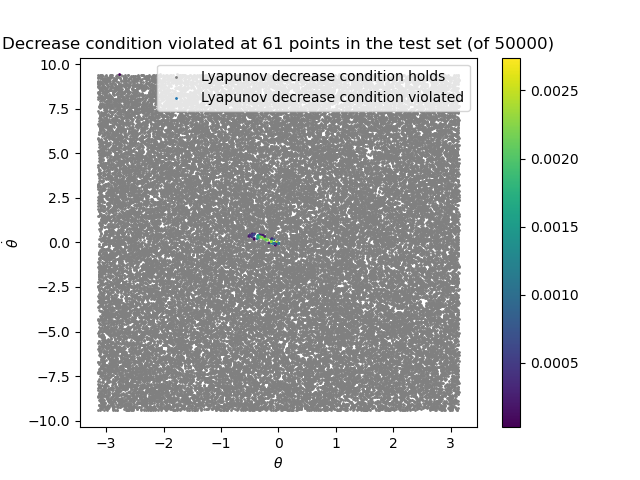

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [154]:
# Plot the violation, if there is any
with torch.no_grad():
        V_values = lyap_function(x_safe_test)
        u = controller(x_safe_test)
        next_state = dynamics_model(torch.hstack((x_safe_test, u)))
        V_next = lyap_function(next_state)
        V_delta_values = V_next - V_values
        
        ok_mask = V_delta_values < 0
        not_ok_mask = V_delta_values >= 0
        fig = plt.figure()
        plt.scatter(x_safe_test[ok_mask, 0], x_safe_test[ok_mask, 1], s=1, c=[0.5, 0.5, 0.5])
        plt.scatter(x_safe_test[not_ok_mask, 0], x_safe_test[not_ok_mask, 1], s=1, c=V_delta_values[not_ok_mask])
        plt.colorbar()
        plt.xlabel("$\\theta$")
        plt.ylabel("$\\dot{\\theta}$")
        plt.legend(["Lyapunov decrease condition holds", "Lyapunov decrease condition violated"])
        plt.title(f"Decrease condition violated at {not_ok_mask.sum()} points in the test set (of {x_safe_test.shape[0]})")

<IPython.core.display.Javascript object>


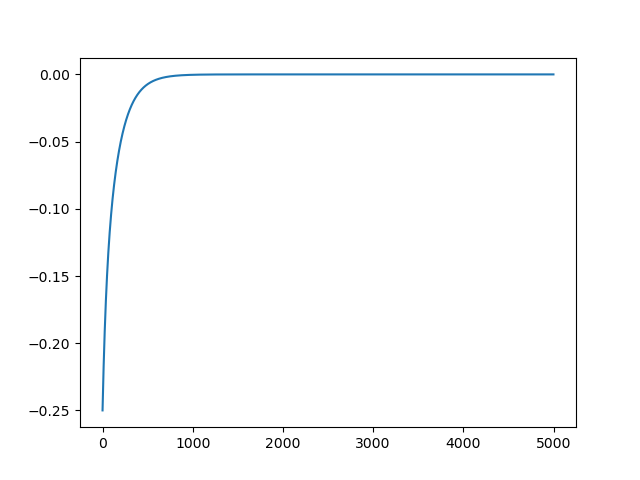

<IPython.core.display.Javascript object>


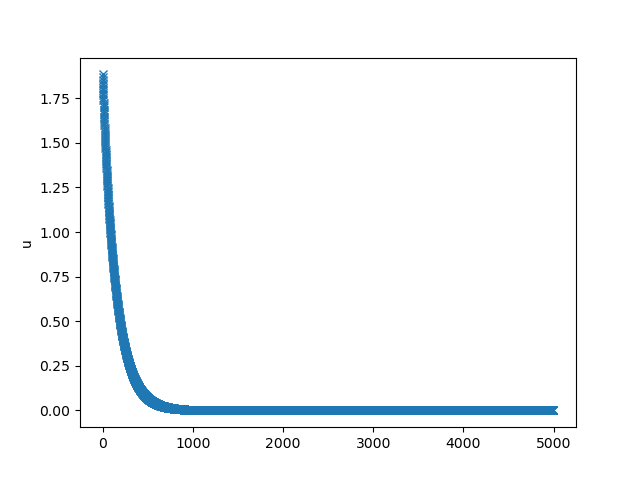

<IPython.core.display.Javascript object>


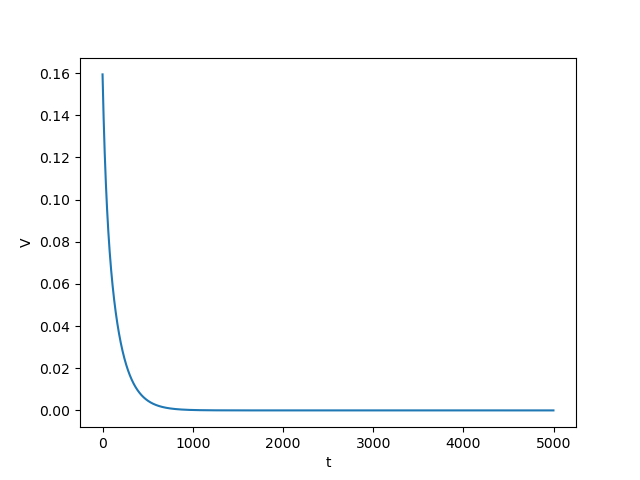

In [155]:
# Simulate a trajectory!
T = 5000
trajectory = torch.zeros((T, 2))
trajectory[0, 0] = -0.25
trajectory[0, 1] = 0.3
controls = torch.zeros((T-1,))
Vs = torch.zeros((T-1,))
predicted_delta_V = torch.zeros((T-1,))

with torch.no_grad():
    for t in range(0, T-1):
        x_now = trajectory[t, :].reshape((1, 2))
#         x_now[0, 2] = torch.fmod(x_now[0, 2], 2*np.pi)
        u = controller(x_now)
        x_next = f_true(x_now.reshape((1, 2)), u)
        trajectory[t+1, :] = x_next.reshape((2,))
        controls[t] = u
        Vs[t] = lyap_function(x_now)
        predicted_delta_V[t] = lyap_function(dynamics_model(torch.hstack((x_now, u)))) - lyap_function(x_now)

    # Plot the trajectoryFigure 2

    plt.figure()
    ax = plt.gca()
    ax.plot(range(0, T), trajectory[:, 0], '-')
    
    plt.figure()
    plt.plot(range(T-1), controls, 'x')
    plt.ylabel('u')
    plt.figure()
    plt.plot(range(T-1), Vs)
    plt.xlabel("t")
    plt.ylabel("V")